<a href="https://colab.research.google.com/github/Ida-bit97/1000_youtube_videos/blob/main/First_project_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this project is to gain a better understanding of the specific characteristics of video that make it worth paying attention to. What tasks are we undertaking in our analysis?

1. Data preprocessing (handling NaN values, ensuring appropriate data types for analysis, checking the distributions of variables, and addressing outlier issues).

2. Exploratory analysis, including categorization using pivot tables and visualizing results.

3. Cluster analysis (determining whether the data has a homogeneous structure or can be divided into segments).


# Part 1. First glance at data

In [ ]:
#packages installation
import math
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import pairwise_distances

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer #визуализация метрик качества
from sklearn.metrics import silhouette_score

!pip install kmodes
from kmodes.kmodes import KModes

In [ ]:
#reading csv data
dt = pd.read_csv("Most popular 1000 Youtube videos.csv")

In [ ]:
#At first glance, the dataset contains seven features, although not all of them provide useful information.
#The "Rank" column serves merely as an index, so we can drop it.
dt.head(5)
dt.drop(dt[['rank']], axis=1, inplace=True)

In [ ]:
#Based on the information table,
#we need to apply some preprocessing transformations for further analysis.
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Video        1000 non-null   object
 1   Video views  1000 non-null   object
 2   Likes        1000 non-null   object
 3   Dislikes     527 non-null    object
 4   Category     982 non-null    object
 5   published    1000 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 47.0+ KB


# Part 2. Preprocessing strategy and its implementation

Preprocessing strategy depends on the type of further analysis. In our case, we have two parts that demand different data condition, so some transformations will be conducted after exploratory and before cluster analysis.

Specification of transformations we conduct to each column:
*   Video - title of each video. We can apply CountVectorizer technique to make title-column work as a set of factors;
*   Video views, Likes, Dislikes - we need to transform type of the data, handle the problem of missing values;
*   Category - we need to conduct some changes with type of the data before cluster analysis;
*   published - it is a year of publication, we need nothing to do with it.



## 2.1. Extracting set of factors from video title using CountVectorizer

In [ ]:
title_only = dt.iloc[:, 0]
title_only

,Video
0,Lil Nas X - Old Town Road (Official Movie) ft....
1,"20 Tennis shots if they were not filmed, NOBOD..."
2,JoJo Siwa - Karma (Official Video)
3,David Kushner - Daylight (Official Music Video)
4,Wiz Khalifa - See You Again ft. Charlie Puth [...
...,...
995,New Champ Kayn/Rhaast Leak for LOL (Moobeat cr...
996,Ford Mustang Launch (street)
997,Eminem is gay - The Interview
998,Yakuza OST - Baka Mitai (ばかみたい) Kiryu full ver...


In [ ]:
#preprocess of video titles - count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re

def preprocess(text):
    text = re.sub(r'\W', ' ', text)  # Removing of punctuation
    text = re.sub(r'\s+', ' ', text)  # Removing extra spaces
    text = text.lower()  # Converting to lowercase
    return text

title_only = title_only.apply(preprocess)

# Initialization of the Count Vectorizer
vectorizer = CountVectorizer(stop_words='english')

# Fitting and transforming the data
cv_matrix = vectorizer.fit_transform(title_only)

# Converting the matrix we got after vectorizing to a Pandas DataFrame
cv_dt = pd.DataFrame(cv_matrix.toarray(), columns=vectorizer.get_feature_names_out())
#cv_dt

In [ ]:
#After conducting vectorization,
#we found that there are too many factors (3192) compared to the number of observations.
#Therefore, we need to set a limit on the frequency of word appearances that we consider appropriate;
#we have set this limit to 20.
droplist = [i for i in cv_dt.columns if cv_dt[i].sum() < 20]
cv_dt.drop(droplist, axis=1, inplace=True)

In [ ]:
#A closer examination of the data reveals that we should exclude prepositions,
#articles, and words whose meanings are ambiguous, such as "la" and "is."
#Additionally, "feat" and "ft" refer to the same concept but are written differently;
#it seems meaningful to treat them as a single feature in our analysis.
cv_dt.columns

Index(['feat', 'ft', 'funny', 'la', 'love', 'music', 'official', 'shorts',
       'video'],
      dtype='object')

In [ ]:
cv_dt.drop(cv_dt[["la"]], axis=1,inplace=True)

cv_dt['feat'] = cv_dt[['feat', 'ft']].sum(axis=1)
cv_dt.drop(cv_dt[["ft"]], axis=1, inplace=True)
cv_dt

,feat,funny,love,music,official,shorts,video
0,1,0,0,0,1,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,1
3,0,0,0,1,1,0,1
4,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0


In [ ]:
#Having transformed video titles into usable factors for future analysis,
#we can now drop the column containing the raw titles.
dt.drop(["Video"], axis=1, inplace=True)

## 2.2. Transforming object-type data of "Video views", "Likes", "Dislikes" to integer

In [ ]:
#filling blanks in Dislikes with 0 values for future transformations
dt.fillna({"Dislikes":"-1"}, inplace = True)
dt["Dislikes"].isna().sum()

np.int64(0)

In [ ]:
#transforming object-type data to integer
list_ = ["Video views", "Likes", "Dislikes"]
for i in range(len(dt["Video views"])):
  for j in range(len(list_)):
    a = int(dt[list_[j]][i].replace(",", ""))
    dt.loc[i, list_[j]] = a

In [ ]:
#replacing Nan values with median
for i in range(len(dt["Dislikes"])):
  if dt["Dislikes"][i] == -1:
    dt.loc[i, "Dislikes"] = dt["Dislikes"].median()

In [ ]:
dt.fillna({"Category": "Unknown"}, inplace=True)
dt["Category"].isna().sum()

np.int64(0)

In [ ]:
dt.columns
dt = dt.astype({'Video views': 'int64', "Likes": 'int64', 'Dislikes': 'int64'})

In [ ]:
#Next, we need to address outliers.
#Let's take a look at the distribution patterns and corresponding boxplots.
#The graphs below indicate that the distributions are skewed.
#The boxplots are nearly invisible due to the high range among data points.
cols = dt.iloc[:, 0:3].columns

for i in range(len(cols)):
  fig = px.box(dt, y=cols[i], points="all")
  fig.show()

In [ ]:
#Outliers can be handled in various ways;
#in our case, it seems reasonable to replace very large values
#with the upper quantile (0.75).
dt['Video views'] = np.where(dt['Video views'] > dt['Video views'].quantile(0.75), dt['Video views'].quantile(0.75), dt['Video views'])
dt['Likes'] = np.where(dt['Likes'] > dt['Likes'].quantile(0.75), dt['Likes'].quantile(0.75), dt['Likes'])
dt['Dislikes'] = np.where(dt['Dislikes'] > dt['Dislikes'].quantile(0.75), dt['Dislikes'].quantile(0.75), dt['Dislikes'])

# Part 3. Exploratory analysis

*From the table below, we see that the categories with the most liked videos are "Music" (431 observations) and "People  Blogs" (257 observations).*

In [ ]:
#pivot table
dt.groupby("Category").count()

,Video views,Likes,Dislikes,published
Category,,,,
Autos & Vehicles,19,19,19,19
Comedy,53,53,53,53
Education,5,5,5,5
Entertainment,81,81,81,81
Film & Animation,29,29,29,29
Gaming,22,22,22,22
Howto & Style,4,4,4,4
Music,431,431,431,431
News & Politics,14,14,14,14


*Visualization also shows that there are more observations from 2016 onward than in previous years. We can observe that 2016, 2017, and 2018 were particularly fruitful for the "People  Blogs" category. However, in subsequent years, the most popular videos were predominantly musical.*

<Figure size 800x400 with 0 Axes>

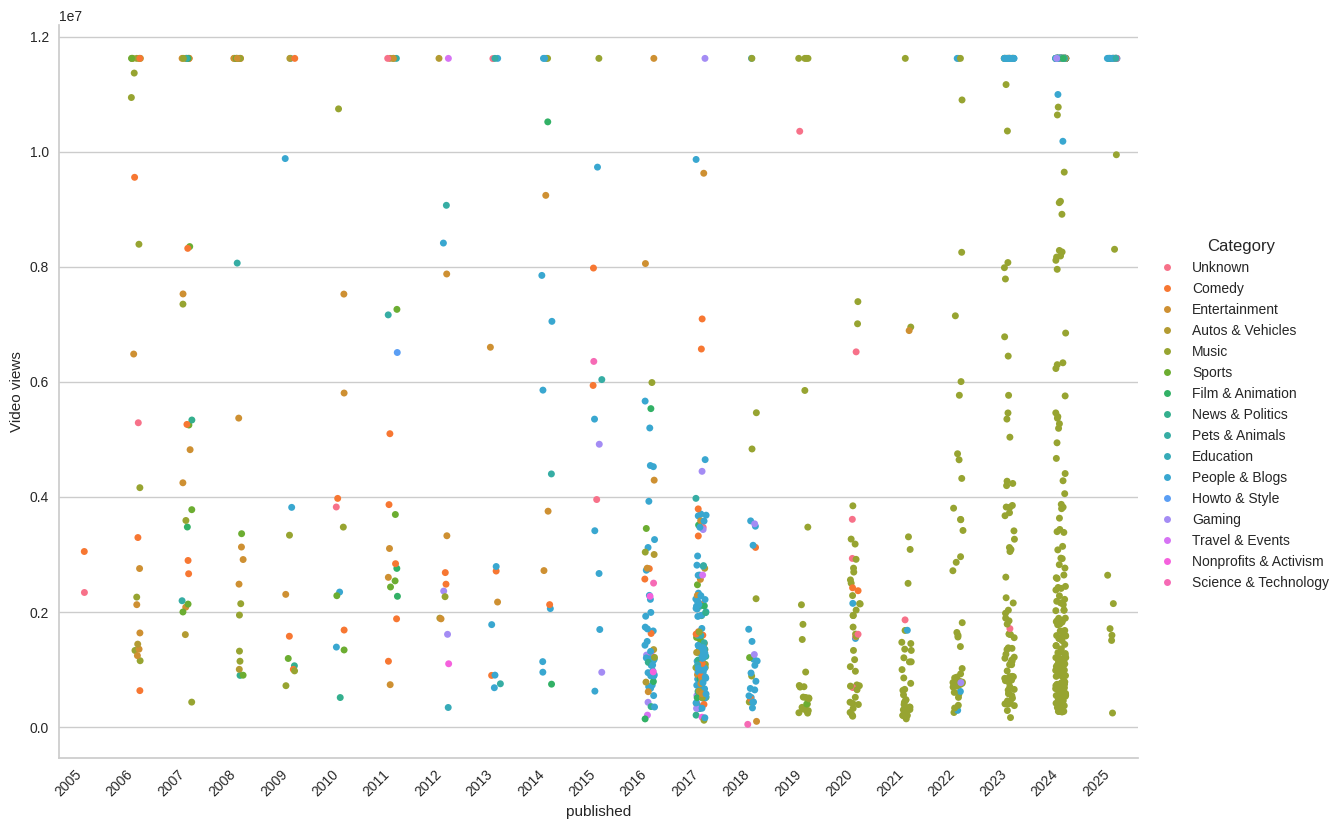

In [ ]:
#visualization of video views categorized by the year
plt.figure(figsize=(8,4))
s = sns.catplot(data=dt, x="published", y="Video views", hue="Category",
                height=8.27, aspect=11.7/8.27)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
)
plt.show()

*Let's take a closer look at the categories for each year. Despite having an insufficient and uneven number of observations for each year, it is worth noting that up to 2017, there was a significantly greater diversity of leading categories, along with high dispersion in dislikes. In contrast, after 2021, the dispersion of dislikes does not exhibit a linear relationship with video views.*

<Figure size 800x400 with 0 Axes>

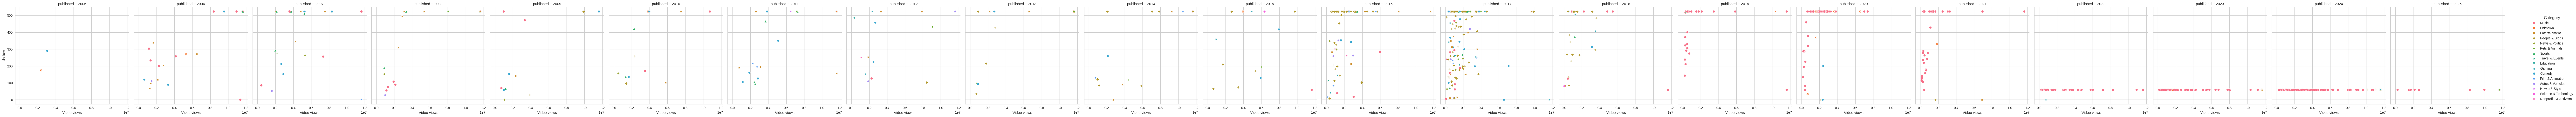

In [ ]:
#categories in each year
plt.figure(figsize=(8,4))
sns.relplot(
    data=dt,
    x="Video views", y="Dislikes", col="published",
    hue="Category", style="Category"
)
plt.show()

Main Findings of Exploratory Analysis:

1. The dataset is highly imbalanced concerning categories and years, which complicates predictive and longitudinal analysis and renders it somewhat meaningless.

2. The absolute leaders in the categories of most liked videos are "Music" (431 observations) and "People  Blogs" (257). However, without knowledge of the data collection process, it is challenging to explain this observation.

3. The years 2016, 2017, and 2018 were fruitful for the "People  Blogs" category. However, in the years following 2018, the most popular videos were predominantly musical.

4. Up until 2017, there was a noticeably greater diversity among leading categories, with a high dispersion in dislikes. In contrast, after 2021, almost all popular videos are musical and receive dislikes that are relatively uniform, regardless of the number of views.


# Part 4. Final transformations for cluster analysis

In [ ]:
scaler = sklearn.preprocessing.RobustScaler()
cols = dt.iloc[:, 0:3].columns
normalized_data = scaler.fit_transform(dt.iloc[:, 0:3])
dt_norm = pd.DataFrame(normalized_data, columns=cols)

In [ ]:
#cv_dt, dt_norm, dt.iloc[:, 3:]
data_list = [dt_norm, cv_dt, dt.iloc[:, 3:]]
dt_new = pd.concat([dt_norm, cv_dt], axis=1)
dt_fin = pd.concat([dt_new, dt.iloc[:, 3:]], axis=1)
dt_fin

,Video views,Likes,Dislikes,feat,funny,love,music,official,shorts,video,Category,published
0,0.872455,0.871404,1.000404,1,0,0,0,1,0,0,Music,2019
1,0.106143,-0.072695,1.000404,0,0,0,0,0,0,0,Unknown,2017
2,0.872455,0.871404,-0.004310,0,0,0,0,1,0,1,Music,2024
3,0.872455,0.871404,-0.002155,0,0,0,1,1,0,1,Music,2023
4,0.872455,0.871404,-0.002155,1,0,0,0,1,0,1,Music,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.140424,-0.183726,0.245657,0,0,0,0,0,0,0,People & Blogs,2017
996,-0.125920,-0.181417,-0.068956,0,0,0,0,0,0,0,Autos & Vehicles,2008
997,0.035452,0.085573,-0.127138,0,0,0,0,0,0,0,Entertainment,2014
998,0.872455,0.871404,-0.127138,0,0,0,0,0,0,0,Gaming,2017


In [ ]:
dict_ = {}
list_ = list(range(1, len(dt_fin['Category'].unique())+1))
for i in range(len(dt_fin['Category'].unique())):
  if dt_fin['Category'].unique()[i] not in dict_:
    dict_[dt_fin['Category'].unique()[i]] = list_[i]

dt_fin['Category'].replace({'Music': 1, 'Unknown': 2, 'Entertainment': 3, 'People & Blogs': 4,
  'News & Politics': 5, 'Pets & Animals': 6, 'Sports': 7, 'Travel & Events': 8, 'Education': 9,
  'Gaming': 10, 'Comedy': 11, 'Film & Animation': 12, 'Autos & Vehicles': 13, 'Howto & Style': 14,
 'Science & Technology': 15, 'Nonprofits & Activism': 16}, inplace=True)

*From the correlation matrix below, we can see that likes and video views are highly correlated (0.74), while likes and dislikes have an even stronger linear relationship than dislikes and video views (0.54 vs. 0.44). The words "official" and "video" are strongly correlated (0.84). No other significant correlations are present.*

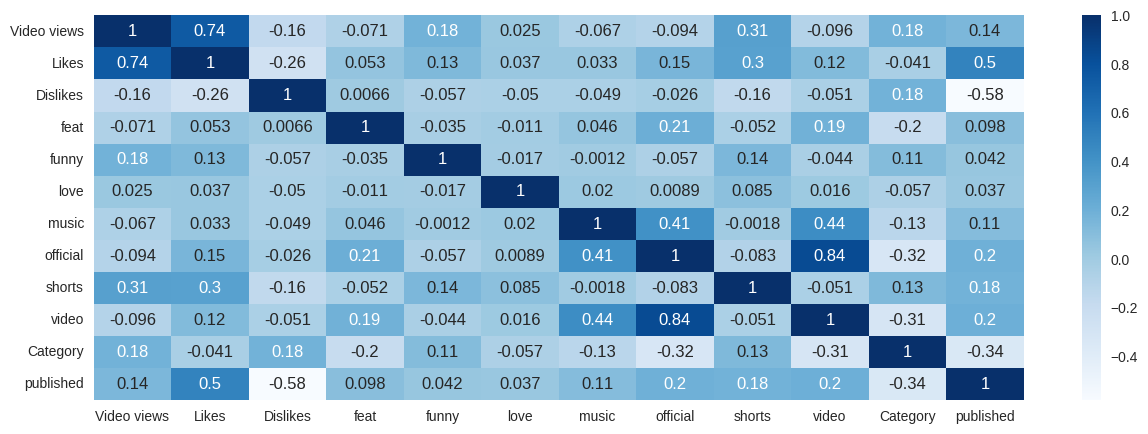

In [ ]:
#correlation matrix
plt.figure(figsize=(15, 5))
sns.heatmap(dt_fin.iloc[:, 0:12].corr(),cmap = 'Blues',annot = True)
plt.show()

In [ ]:
dt_fin

,Video views,Likes,Dislikes,feat,funny,love,music,official,shorts,video,Category,published
0,0.872455,0.871404,1.000404,1,0,0,0,1,0,0,1,2019
1,0.106143,-0.072695,1.000404,0,0,0,0,0,0,0,2,2017
2,0.872455,0.871404,-0.004310,0,0,0,0,1,0,1,1,2024
3,0.872455,0.871404,-0.002155,0,0,0,1,1,0,1,1,2023
4,0.872455,0.871404,-0.002155,1,0,0,0,1,0,1,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.140424,-0.183726,0.245657,0,0,0,0,0,0,0,4,2017
996,-0.125920,-0.181417,-0.068956,0,0,0,0,0,0,0,13,2008
997,0.035452,0.085573,-0.127138,0,0,0,0,0,0,0,3,2014
998,0.872455,0.871404,-0.127138,0,0,0,0,0,0,0,10,2017


# Part 5. Cluster analysis using K-modes

K-modes as an algorithm was chosen because we have a mixed-type data (categorical, numerical and ordinal).

*The Elbow curve shows a slight elbow at point 2 and 3, suggesting that the dataset may not be easily clustered. Nonetheless, we will give it a try.*

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 3864.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 3864.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 3864.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 3864.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 3864.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 157, cost: 3607.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 188, cost: 3392.0
Init: initializing centroids
Init: initializing clusters
Starting iterations..

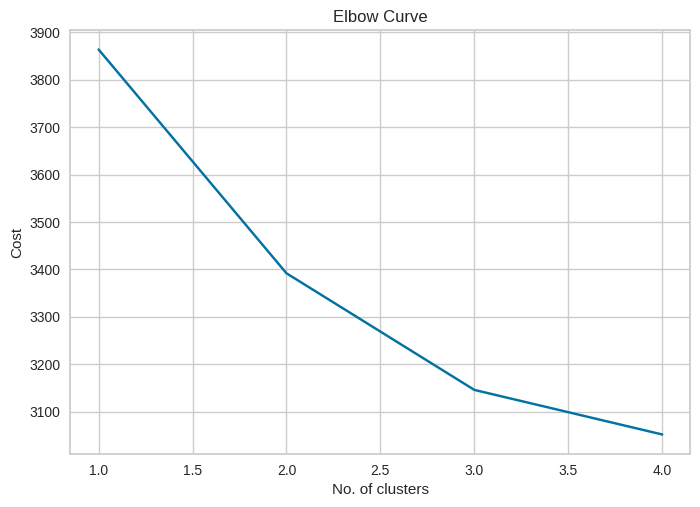

In [ ]:
#elbow curve
cost = []
K = range(1,5)
for k in list(K):
    kmode = KModes(n_clusters=k, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(dt_fin)
    cost.append(kmode.cost_)

plt.plot(K, cost, 'x-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Curve')
plt.show()

*The SilhouetteVisualizer provides a more detailed view of what happens with clusters of different sizes. We can observe that regardless of the number of clusters, all models are quite inaccurate (with the best scoring only 0.2).*

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 392, cost: 3392.0
Run 1, iteration: 2/100, moves: 40, cost: 3392.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 35, cost: 3588.0
Run 2, iteration: 2/100, moves: 3, cost: 3588.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 25, cost: 3588.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 309, cost: 3607.0
Run 4, iteration: 2/100, moves: 1, cost: 3607.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 232, cost: 3397.0
Run 5, iteration: 2/100, moves: 62, cost: 3397.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 249, cost: 3314.0
Run 1,

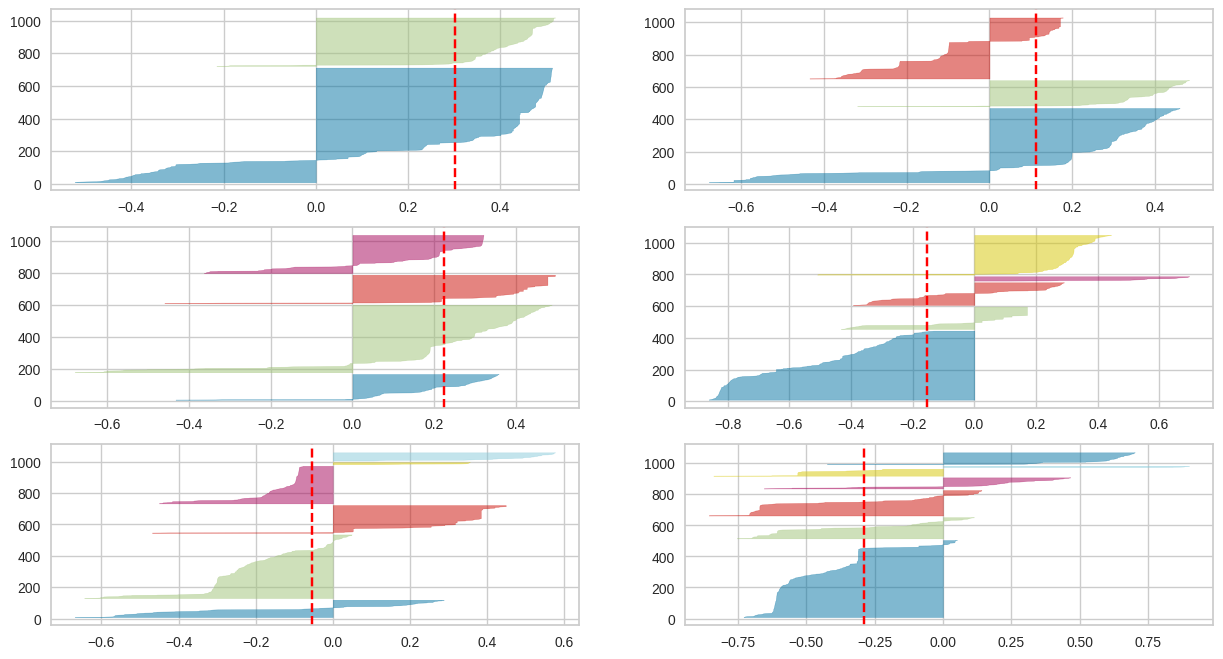

In [ ]:
#SilhouetteVisualizer
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    km = KModes(n_clusters=i, init='random', n_init = 5, verbose=1, random_state=42)
    km.fit_predict(dt_fin)
    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(dt_fin)

*The Davies-Bouldin index for a two-cluster division—which is used for measuring clustering quality—is relatively high (3), indicating that the clusters are not well separated from one another.*

In [ ]:
k_modes = KModes(n_clusters=2, init = "random", n_init = 5, verbose=1, random_state=42)
clusters = k_modes.fit_predict(dt_fin)

def davis_bouldin_index(X, labels):
#X: df_values, labels = clusters
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)


    X = pd.DataFrame(X)
    cluster_centers = np.array([X[labels == label].mode().iloc[0].values for label in unique_labels])


    distances = pairwise_distances(cluster_centers, metric='hamming')


    intra_cluster_distances = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        intra_distance = np.mean(pairwise_distances(cluster_points, metric='hamming'))
        intra_cluster_distances.append(intra_distance)


    db_index = 0.0
    for i in range(n_clusters):
        max_ratio = 0.0
        for j in range(n_clusters):
            if i != j:
                ratio = (intra_cluster_distances[i] + intra_cluster_distances[j]) / distances[i][j]
                if ratio > max_ratio:
                    max_ratio = ratio
        db_index += max_ratio

    db_index /= n_clusters
    return db_index


dbi = davis_bouldin_index(dt_fin.values, clusters)
print(f"Davies-Bouldin Index: {dbi}")

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 392, cost: 3392.0
Run 1, iteration: 2/100, moves: 40, cost: 3392.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 35, cost: 3588.0
Run 2, iteration: 2/100, moves: 3, cost: 3588.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 25, cost: 3588.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 309, cost: 3607.0
Run 4, iteration: 2/100, moves: 1, cost: 3607.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 232, cost: 3397.0
Run 5, iteration: 2/100, moves: 62, cost: 3397.0
Best run was number 1
Davies-Bouldin Index: 3.054345947584859


The K-modes algorithm does not perform well on this dataset, as indicated by the results from the Elbow curve, Silhouette score, and Davies-Bouldin Index. All these metrics suggest that there is little value in clustering the data.